### AWS Sagemaker XGBoost CV Best Models Evaluation and Feature Importance

Purpose: perform prediction, evaluate (ROC-AUC and Gini) the results and extract feature importance and feature iterations from an XGBoost classification models extracted from XGBoost CV and saved (all) into output.tar.gz in S3. The file with many models can not be used to create a Sagemaker Model object and used in a batch transform job. ScriptProcessor based on xgboost image and processing job is used instead. It's still kind of an evaluation, searching of a best model process, not yet a final step.

Model scores and feature importance are extracted from S3, visualized and saved into a log file. Feature Interaction files as well as a file with predictions just exist in the output S3 bucket.

In [24]:
Experiments_file='/home/kate/Research/Property/Notebooks/Experiments/Logs/Set2-Classification.xlsx'
AllExperiments_tab='Experiments'
Experiment_name='Test2020'
#Experiment configuration:  
#Predict on the same dataset set but for different model files all inside output.tar.gz
#1.each line in the file contains the model name and set of features to built a dataset for prediction
Experiment_Features_tab='%s Models'%Experiment_name
#2.ModelFiles: each line is a model name (Model) and full model file name (ModelData - output.tar.gz) in an S3 bucket
Experiment_ModelFiles_tab='%s ModelFiles'%Experiment_name

path_to_model_evals='Data/Experiments/%s'%Experiment_name
 
bucket='kdproperty'
path_to_data_file='/Data/'

instance_type='ml.m5.xlarge'
instance_count=1

Trial_name_processing='%s-Processing'%Experiment_name

split_year='2020'

In [2]:
import boto3
import sys
import time
import pandas as pd
import numpy as np

import re

#to read data from S3 with pandas
import s3fs

import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
from sagemaker.processing import ScriptProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

In [3]:
region = boto3.session.Session().region_name
role = 'arn:aws:iam::757107622481:role/service-role/AmazonSageMaker-ExecutionRole-20200819T131882'
sagemaker_session = sagemaker.session.Session(default_bucket=bucket)
s3 = s3fs.S3FileSystem()

In [4]:
#sys.path.append('/home/kate/Research/YearBuilt/Notebooks/Experiments')
import ExperimentsUtils as eu

1. Reading experiment configuration from an excel file

In [5]:
experiments = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=AllExperiments_tab)

1.1 Target variable and data file name

In [6]:
target=experiments[experiments['Experiment']==Experiment_name]['Target'].values[0]
print('Target of models in %s experiment is %s'%(Experiment_name,target))
data_file=experiments[experiments['Experiment']==Experiment_name]['Dataset'].values[0]
print('Datafile used in %s experiment is %s'%(Experiment_name,data_file))

Target of models in Test2020 experiment is hasclaim
Datafile used in Test2020 experiment is property_water_claims_non_cat_fs_v6.csv


1.2 Model files (usually output.tar.gz produced from training)
I do not create SageMaker Models in this process. It's still evaluation part and a simple ScriptProcessor is used for prediction which does not need Sagemaker Model object

In [7]:
model_files = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_ModelFiles_tab)
model_files

,Model,ModelData
0,BaseModel,s3://kdproperty/Models/Experiments/Exp1/BaseMo...


1.3 Model features. The process will use this info to create a data file with all needed features and map feature importance

In [8]:
model_features = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_Features_tab)
model_features

,Model,F1,F2,F3,F4,F5,F6
0,BaseModel,cal_year-yearbuilt,cova_deductible,sqft,customer_cnt_active_policies,usagetype_encd,water_risk_3_blk


2.Verification if we have the same set of models in both configurations

In [9]:
models_from_model_features=model_features['Model'].tolist()
models_from_models_files=model_files['Model'].tolist()
if len([x for x in models_from_model_features if x not in models_from_models_files])!=0:
    raise Exception('Different set of models in featuresets and files!')

3.Creating experiments and trials in SageMaker. SageMaker Experiment object does not contain useful info from the process except name of the job. 

In [10]:
eu.cleanup_experiment(Experiment_name)
eu.create_experiment(Experiment_name)
eu.create_trial(Experiment_name,Trial_name_processing)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


4. Processing jobs

In [11]:
%%writefile CVBestModelsEvaluation.py
import argparse
import os
import sys
import subprocess
import pathlib
import pickle
import tarfile
import joblib
import numpy as np
import pandas as pd
import xgboost


#Evaluation metric
from sklearn.metrics import roc_auc_score
#To estimate models performance we need a custom gini function
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def create_fmap(ModelName,featureset):
    fmap_filename='%s.fmap'%ModelName
    outfile = open(fmap_filename, 'w')
    for i, feat in enumerate(featureset):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    return fmap_filename

if __name__=='__main__':
    
    #installing XGBFir
    XGBFirFlg = False
    try:
        xgbfir_installed = subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xgbfir'])
        if xgbfir_installed == 0:
            import xgbfir
            XGBFirFlg = True
            print('Successfully installed XGBfir')
        else:
            print('XGBfir was not installed')
    except:
        print('XGBfir was not installed')
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_file', type=str)
    parser.add_argument('--split_year', type=int)       
    parser.add_argument('--model', type=str)
    parser.add_argument('--featureset', type=str)     
    parser.add_argument('--target', type=str)
    args, _ = parser.parse_known_args()    
    print('Received arguments {}'.format(args))
    
    featureset=args.featureset.split(',')
    target_column=args.target
    #prediction will be added into the dataset in column "model_name-fold"
    model_name=args.model
    models_path = '/opt/ml/processing/input/model/'
    models_file='output.tar.gz'
    input_data_path = os.path.join('/opt/ml/processing/input', args.data_file)
    auc_metrics_data_path = '/opt/ml/processing/output_metrics/auc_metrics.csv'
    gini_metrics_data_path = '/opt/ml/processing/output_metrics/gini_metrics.csv'    
    importance_data_path = '/opt/ml/processing/output_importance/importance.csv'    
    prediction_data_path = '/opt/ml/processing/output_prediction/prediction.csv' 
    
    print('Extracting models from file %s'%os.path.join(models_path, models_file))
    with tarfile.open(os.path.join(models_path, models_file)) as tar:
        tar.extractall(models_path)
    
    

    print('Reading dataset from %s'%input_data_path)
    dataset = pd.read_csv(input_data_path, error_bad_lines=False, index_col=False)
    
    print('Creating dataset for prediction')
    test_dataset = pd.DataFrame()
    for f in featureset:
        print(f)
        test_dataset[f]=dataset.eval(f)
    dataset[target_column]=dataset.eval(target_column) 
    
    print('Creating DMatrix from dataset for prediction')
    X_test = xgboost.DMatrix(test_dataset.values)
    
    #loop thru available models in output.tar.gz which are xgboost-model-fold
    #assuming maximum models available is 10 from 0 to 9 in the last position of the file name
    Prediction_df = pd.DataFrame()
    Scores_df = pd.DataFrame()
    FI_df = pd.DataFrame() 
    for filename in os.listdir(models_path):
        if filename.startswith('xgboost-model-fold'):
            print('Processing model %s...'%filename)
            ind=int(filename[-1])
            print('1. Extracting model')
            model = pickle.load(open(os.path.join(models_path, filename),'rb'))
            
            print('2. Prediction')
            predictions = model.predict(X_test)
            prediction_column_name='%s-%s'%(model_name,ind)
            dataset[prediction_column_name]=predictions
            Prediction_df=pd.concat([Prediction_df,dataset['%s-%s'%(args.model,ind)]],axis=1)
            
    
            print('3. Evaluation')
            test_roc_auc=roc_auc_score(dataset[(dataset.cal_year == args.split_year)][target_column], dataset[(dataset.cal_year == args.split_year)][prediction_column_name])
            train_roc_auc=roc_auc_score(dataset[(dataset.cal_year < args.split_year)][target_column], dataset[(dataset.cal_year < args.split_year)][prediction_column_name])
    
            test_gini=gini(dataset[(dataset.cal_year == args.split_year)][target_column],dataset[(dataset.cal_year == args.split_year)][prediction_column_name])/gini(dataset[(dataset.cal_year == args.split_year)][target_column],dataset[(dataset.cal_year == args.split_year)][target_column])
            train_gini=gini(dataset[(dataset.cal_year < args.split_year)][target_column],dataset[(dataset.cal_year < args.split_year)][prediction_column_name])/gini(dataset[(dataset.cal_year < args.split_year)][target_column],dataset[(dataset.cal_year < args.split_year)][target_column])
    
            TestingDataResults = pd.DataFrame(list(zip([model_name],[ind],[train_roc_auc],[test_roc_auc],[train_gini],[test_gini])), 
               columns =['Model','fold','Train ROC-AUC','Test ROC-AUC','Train gini','Test gini'])
      
            Scores_df=pd.concat([Scores_df,TestingDataResults])
            
    
            print('4. Feature Importance')
    
            fmap_filename=create_fmap(model_name,featureset)
            feat_imp = pd.Series(model.get_score(fmap=fmap_filename,importance_type='weight')).to_frame()
            feat_imp.columns=['Weight']
            feat_imp = feat_imp.join(pd.Series(model.get_score(fmap=fmap_filename,importance_type='gain')).to_frame())
            feat_imp.columns=['Weight','Gain']
            feat_imp = feat_imp.join(pd.Series(model.get_score(fmap=fmap_filename,importance_type='cover')).to_frame())
            feat_imp.columns=['Weight','Gain','Cover']
            feat_imp['FeatureName'] = feat_imp.index
            feat_imp['Model'] = model_name
            feat_imp['fold'] = ind
            
            FI_df=pd.concat([FI_df,feat_imp])
  
            if XGBFirFlg:
                print('Feature Interaction')
                interactions_data_path = '/opt/ml/processing/output_importance/interactions_%s_%s.xlsx'%(model_name,ind)
                xgbfir.saveXgbFI(model, feature_names=featureset,  TopK = 500,  MaxTrees = 500, MaxInteractionDepth = 2, OutputXlsxFile = interactions_data_path)           
    
    print('Averaging results')
    #FI
    num_folds=FI_df['fold'].max()+1
    #number of columns with folds scores depends on the number of folds (num_folds) We do not know in advance how many of them exist in the results
    folds_train_columns=[]
    folds_test_columns=[]
    folds_gain_columns=[]
    folds_weight_columns=[]
    folds_cover_columns=[]
    for i in range(0,int(num_folds),1):
        folds_train_columns.append('train-%s-fold'%i)
        folds_test_columns.append('test-%s-fold'%i)
        folds_gain_columns.append('gain-%s'%i)
        folds_weight_columns.append('weight-%s'%i)
        folds_cover_columns.append('cover-%s'%i)
    print('1. Feature importance')
    FI_gain=FI_df[['Model','fold','FeatureName','Gain']]
    FI_gain=FI_gain.sort_values(['Model','fold'], ascending=[False,True])
    FI_gain = pd.pivot_table(FI_gain, index=['Model','FeatureName'], columns=['fold'])
    FI_gain.reset_index( drop=False, inplace=True )
    FI_gain.columns = FI_gain.columns.droplevel(0)
    FI_gain.columns =['Model','feature']+folds_gain_columns
    FI_gain['gain-mean']=FI_gain[folds_gain_columns].mean(axis=1)
    FI_gain['gainc-std']=FI_gain[folds_gain_columns].std(axis=1)
    FI_gain['gain-sem']=FI_gain[folds_gain_columns].sem(axis=1)
    #
    FI_weight=FI_df[['Model','fold','FeatureName','Weight']]
    FI_weight=FI_weight.sort_values(['Model','fold'], ascending=[False,True])
    FI_weight = pd.pivot_table(FI_weight, index=['Model','FeatureName'], columns=['fold'])
    FI_weight.reset_index( drop=False, inplace=True )
    FI_weight.columns = FI_weight.columns.droplevel(0)
    FI_weight.columns =['Model','feature']+folds_weight_columns
    FI_weight['weight-mean']=FI_weight[folds_weight_columns].mean(axis=1)
    FI_weight['weightc-std']=FI_weight[folds_weight_columns].std(axis=1)
    FI_weight['weight-sem']=FI_weight[folds_weight_columns].sem(axis=1)   
    #
    FI_cover=FI_df[['Model','fold','FeatureName','Cover']]
    FI_cover=FI_cover.sort_values(['Model','fold'], ascending=[False,True])
    FI_cover = pd.pivot_table(FI_cover, index=['Model','FeatureName'], columns=['fold'])
    FI_cover.reset_index( drop=False, inplace=True )
    FI_cover.columns = FI_cover.columns.droplevel(0)
    FI_cover.columns =['Model','feature']+folds_cover_columns
    FI_cover['cover-mean']=FI_cover[folds_cover_columns].mean(axis=1)
    FI_cover['coverc-std']=FI_cover[folds_cover_columns].std(axis=1)
    FI_cover['cover-sem']=FI_cover[folds_cover_columns].sem(axis=1) 
    FI_df=pd.merge(FI_gain, FI_weight, on=['Model','feature'], how='inner')
    FI_df=pd.merge(FI_df, FI_cover, on=['Model','feature'], how='inner')
    
    print('Saving importance...')
    FI_df.to_csv(importance_data_path, header=True, index=False)
    
    print('2. Prediction')
    Prediction_df[model_name]=Prediction_df.mean(axis=1)
    dataset[model_name]=Prediction_df[model_name]
    
    print('Saving predictions...')
    Prediction_df.to_csv(prediction_data_path, header=True, index=False)
    
    print('2. Scores')
    
    
    train_ROCAUC = Scores_df[['Model','fold','Train ROC-AUC']].copy()
    train_ROCAUC.columns=['Model','fold','train:auc']
    train_ROCAUC=train_ROCAUC.sort_values(['Model','fold'], ascending=[False,True])
    train_ROCAUC = pd.pivot_table(train_ROCAUC, index=['Model'], columns=['fold'])
    train_ROCAUC.reset_index( drop=False, inplace=True )
    train_ROCAUC.columns = train_ROCAUC.columns.droplevel(0)
    train_ROCAUC.columns =['Model']+folds_train_columns
    train_ROCAUC['train-auc-mean']=train_ROCAUC[folds_train_columns].mean(axis=1)
    train_ROCAUC['train-auc-std']=train_ROCAUC[folds_train_columns].std(axis=1)
    train_ROCAUC['train-auc-sem']=train_ROCAUC[folds_train_columns].sem(axis=1)

    test_ROCAUC = Scores_df[['Model','fold','Test ROC-AUC']].copy()
    test_ROCAUC.columns=['Model','fold','test:auc']
    test_ROCAUC=test_ROCAUC.sort_values(['Model','fold'], ascending=[False,True])
    test_ROCAUC = pd.pivot_table(test_ROCAUC, index=['Model'], columns=['fold'])
    test_ROCAUC.reset_index( drop=False, inplace=True )
    test_ROCAUC.columns = test_ROCAUC.columns.droplevel(0)
    test_ROCAUC.columns =['Model']+folds_test_columns
    test_ROCAUC['test-auc-mean']=test_ROCAUC[folds_test_columns].mean(axis=1)
    test_ROCAUC['test-auc-std']=test_ROCAUC[folds_test_columns].std(axis=1)
    test_ROCAUC['test-auc-sem']=test_ROCAUC[folds_test_columns].sem(axis=1)
    
    AUC_Scores_df = pd.merge(train_ROCAUC, test_ROCAUC, on=['Model'], how='inner')
    
    train_gini = Scores_df[['Model','fold','Train gini']].copy()
    train_gini.columns=['Model','fold','train:gini']
    train_gini=train_gini.sort_values(['Model','fold'], ascending=[False,True])
    train_gini = pd.pivot_table(train_gini, index=['Model'], columns=['fold'])
    train_gini.reset_index( drop=False, inplace=True )
    train_gini.columns = train_gini.columns.droplevel(0)
    train_gini.columns =['Model']+folds_train_columns
    train_gini['train-gini-mean']=train_gini[folds_train_columns].mean(axis=1)
    train_gini['train-gini-std']=train_gini[folds_train_columns].std(axis=1)
    train_gini['train-gini-sem']=train_gini[folds_train_columns].sem(axis=1)
    
    
    test_gini = Scores_df[['Model','fold','Test gini']].copy()
    test_gini.columns=['Model','fold','test:gini']
    test_gini=test_gini.sort_values(['Model','fold'], ascending=[False,True])
    test_gini = pd.pivot_table(test_gini, index=['Model'], columns=['fold'])
    test_gini.reset_index( drop=False, inplace=True )
    test_gini.columns = test_gini.columns.droplevel(0)
    test_gini.columns =['Model']+folds_test_columns
    test_gini['test-gini-mean']=test_gini[folds_test_columns].mean(axis=1)
    test_gini['test-gini-std']=test_gini[folds_test_columns].std(axis=1)
    test_gini['test-gini-sem']=test_gini[folds_test_columns].sem(axis=1)
    
    gini_Scores_df = pd.merge(train_gini, test_gini, on=['Model'], how='inner')
    
    print('3. Scores on folds average prediction')
    
    test_roc_auc=roc_auc_score(dataset[(dataset.cal_year == args.split_year)][target_column], dataset[(dataset.cal_year == args.split_year)][model_name])
    train_roc_auc=roc_auc_score(dataset[(dataset.cal_year < args.split_year)][target_column], dataset[(dataset.cal_year < args.split_year)][model_name])
    
    test_gini=gini(dataset[(dataset.cal_year == args.split_year)][target_column],dataset[(dataset.cal_year == args.split_year)][model_name])/gini(dataset[(dataset.cal_year == args.split_year)][target_column],dataset[(dataset.cal_year == args.split_year)][target_column])
    train_gini=gini(dataset[(dataset.cal_year < args.split_year)][target_column],dataset[(dataset.cal_year < args.split_year)][model_name])/gini(dataset[(dataset.cal_year < args.split_year)][target_column],dataset[(dataset.cal_year < args.split_year)][target_column])
    
    TestingDataResults = pd.DataFrame(list(zip([model_name],[-1],[train_roc_auc],[test_roc_auc],[train_gini],[test_gini])), 
               columns =['Model','fold','Train ROC-AUC','Test ROC-AUC','Train gini','Test gini'])
      
    FinalDataResults = pd.DataFrame(list(zip([train_roc_auc],[test_roc_auc],[train_gini],[test_gini])), 
               columns =['final-train-auc','final-test-auc','final-train-gini','final-test-gini'])
    
    AUC_Scores_df=pd.concat([AUC_Scores_df,FinalDataResults[['final-train-auc','final-test-auc']]],axis=1)
    gini_Scores_df=pd.concat([gini_Scores_df,FinalDataResults[['final-train-gini','final-test-gini']]],axis=1)
    
    print('Saving scores...')
    AUC_Scores_df.to_csv(auc_metrics_data_path, header=True, index=False)
    gini_Scores_df.to_csv(gini_metrics_data_path, header=True, index=False)

Overwriting CVBestModelsEvaluation.py


In [12]:
models = pd.merge(model_features, model_files, on='Model', how='inner')
models

,Model,F1,F2,F3,F4,F5,F6,ModelData
0,BaseModel,cal_year-yearbuilt,cova_deductible,sqft,customer_cnt_active_policies,usagetype_encd,water_risk_3_blk,s3://kdproperty/Models/Experiments/Exp1/BaseMo...


In [13]:
from sagemaker.amazon.amazon_estimator import get_image_uri
processors=list()
image_uri = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='1.0-1') 
regex = re.compile('F[ 0-9]')
for index, row in models.iterrows():
    model=row['Model']

    
    featureset = []
    for c in models.columns:
        if bool(re.match(regex, c)):
            featureset.append(row[c])
    print (index, ': Prediction from model %s: %s'%(model,','.join(featureset).replace(' ','')))
    data_processor = ScriptProcessor(
    image_uri=image_uri,
    command=['python3'],
    instance_type=instance_type,
    instance_count=instance_count,
    base_job_name=model.replace('_','-'),
    role=role)

    data_processor.run(code='CVBestModelsEvaluation.py',
                        inputs=[ProcessingInput(source='s3://%s%s'%(bucket,path_to_data_file+data_file),destination='/opt/ml/processing/input'),
                                ProcessingInput(source=row['ModelData'],destination='/opt/ml/processing/input/model'),                              
                               ],
                        outputs=[
                        ProcessingOutput(output_name='metrics', source='/opt/ml/processing/output_metrics', destination='s3://%s/%s/output_metrics/%s'%(bucket,path_to_model_evals,model)),
                        ProcessingOutput(output_name='importance', source='/opt/ml/processing/output_importance', destination='s3://%s/%s/output_importance/%s'%(bucket,path_to_model_evals,model)) ,
                        ProcessingOutput(output_name='prediction', source='/opt/ml/processing/output_prediction', destination='s3://%s/%s/output_prediction/%s'%(bucket,path_to_model_evals,model))
                                ],
                        arguments=['--data_file',data_file,                                 
                                 '--model',model,
                                 '--featureset', ','.join(featureset).replace(' ',''),
                                 '--target',target,
                                 '--split_year',split_year],
                        experiment_config = {
        'ExperimentName': Experiment_name ,
        'TrialName' : Trial_name_processing,
        'TrialComponentDisplayName' : Trial_name_processing},
                        wait=False
                        )
    processors.append(data_processor)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


0 : Prediction from model BaseModel: cal_year-yearbuilt,cova_deductible,sqft,customer_cnt_active_policies,usagetype_encd,water_risk_3_blk


INFO:sagemaker:Creating processing-job with name BaseModel-2021-06-16-20-36-59-115



Job Name:  BaseModel-2021-06-16-20-36-59-115
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://kdproperty/Data/property_water_claims_non_cat_fs_v6.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://kdproperty/Models/Experiments/Exp1/BaseModel-1-2021-06-16-15-16-46/output/output.tar.gz', 'LocalPath': '/opt/ml/processing/input/model', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-757107622481/BaseModel-2021-06-16-20-36-59-115/input/code/CVBestModelsEvaluation.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicate

In [14]:
#wait till the rest of processing jobs complete
eu.wait_processing_jobs(processors=processors,check_every_sec=10,print_every_n_output=10,wait_min=60)

Processing job BaseModel-2021-06-16-20-36-59-115 status: InProgress
Continue waiting...
Processing job BaseModel-2021-06-16-20-36-59-115 status: InProgress
Continue waiting...
Processing job BaseModel-2021-06-16-20-36-59-115 status: InProgress
Continue waiting...
Processing job BaseModel-2021-06-16-20-36-59-115 status: InProgress
Continue waiting...
All Processing Jobs are Completed


5. Reading results, visualisation  and saving into the log experiment

In [15]:
#Output files locations
FileLocations_df=pd.DataFrame(columns=['Model', 'AUC Scores', 'gini Scores', 'Importance', 'Interactions','Prediction'])
for index, row in models.iterrows():
    model=row['Model']
    AUC_Scores_location='s3://%s/%s/output_metrics/%s/auc_metrics.csv'%(bucket,path_to_model_evals,model)
    gini_Scores_location='s3://%s/%s/output_metrics/%s/gini_metrics.csv'%(bucket,path_to_model_evals,model)
    FI_location='s3://%s/%s/output_importance/%s/importance.csv'%(bucket,path_to_model_evals,model)
    Interactions_location='s3://%s/%s/output_importance/%s/interactions_%s_FoldNumber.xlsx'%(bucket,path_to_model_evals,model,model)
    Prediction_location='s3://%s/%soutput_prediction/%s/prediction.csv'%(bucket,path_to_model_evals,model)
    FileLocations_df.loc[index]=[model, AUC_Scores_location,gini_Scores_location,FI_location,Interactions_location,Prediction_location]

In [16]:
#Saving into the Experiment log 
eu.SaveToExperimentLog(Experiments_file, '%s OutputData'%Experiment_name, FileLocations_df)

In [17]:
AUC_Scores=pd.DataFrame()
gini_Scores=pd.DataFrame()
FeatureImportance = pd.DataFrame()
for index, row in models.iterrows():
    model=row['Model']
    
    AUC_Scores_location='s3://%s/%s/output_metrics/%s/auc_metrics.csv'%(bucket,path_to_model_evals,model) 
    ModelAUC_Scores=pd.read_csv(AUC_Scores_location,  error_bad_lines=False, index_col=False) 
    AUC_Scores = AUC_Scores.append(ModelAUC_Scores, ignore_index=True)    
    
    gini_Scores_location='s3://%s/%s/output_metrics/%s/gini_metrics.csv'%(bucket,path_to_model_evals,model) 
    Modelgini_Scores=pd.read_csv(gini_Scores_location,  error_bad_lines=False, index_col=False) 
    gini_Scores = gini_Scores.append(Modelgini_Scores, ignore_index=True)     
    
    FI_location='s3://%s/%s/output_importance/%s/importance.csv'%(bucket,path_to_model_evals,model) 
    ModelFeatureImportance=pd.read_csv(FI_location,  error_bad_lines=False, index_col=False) 
    FeatureImportance = FeatureImportance.append(ModelFeatureImportance, ignore_index=True)    


<ipython-input-18-1c6d190ba8bc>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values,rotation=90)
<ipython-input-18-1c6d190ba8bc>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values,rotation=90)
<ipython-input-18-1c6d190ba8bc>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values,rotation=90)


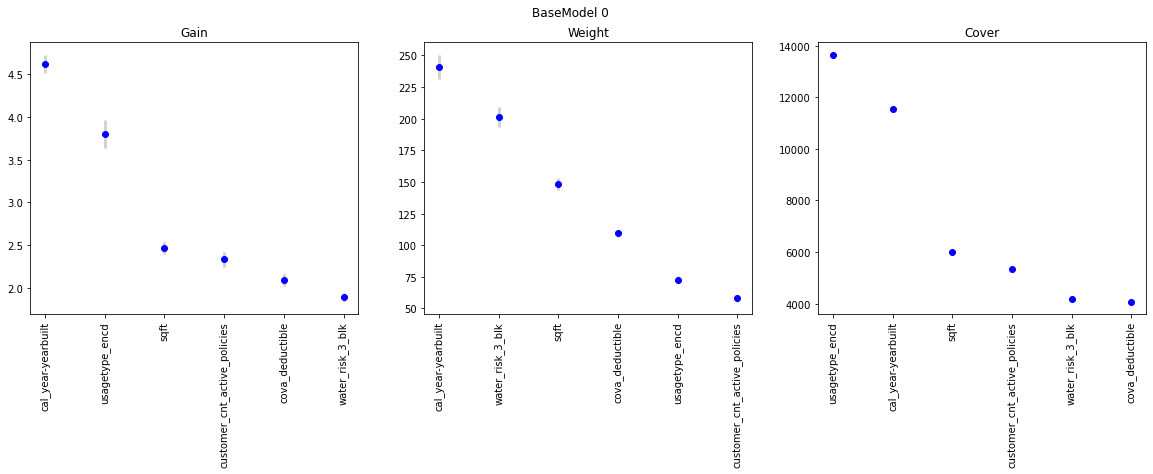

In [18]:
for index, row in models.iterrows():
        data=FeatureImportance.sort_values('gain-mean',ascending=False)
        fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(20,5)) 
        fig.suptitle('%s %s'%(row['Model'],index))
                
        ax = axs[0]
        ax.errorbar(data['feature'], data['gain-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['gain-sem'], fmt='o')
        ax.set_title('Gain')
        ax.set_xticklabels(data['feature'].values,rotation=90)
           
 
        data=data.sort_values('weight-mean',ascending=False)
        ax = axs[1]
        ax.errorbar(data['feature'], data['weight-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['weight-sem'], fmt='o')
        ax.set_title('Weight')
        ax.set_xticklabels(data['feature'].values,rotation=90)
                         
        data=data.sort_values('cover-mean',ascending=False)
        ax = axs[2]
        ax.errorbar(data['feature'], data['cover-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['weight-sem'], fmt='o')
        ax.set_title('Cover')
        ax.set_xticklabels(data['feature'].values,rotation=90)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Text(0.5, 0.98, 'Means of AUC with standard error of the mean')

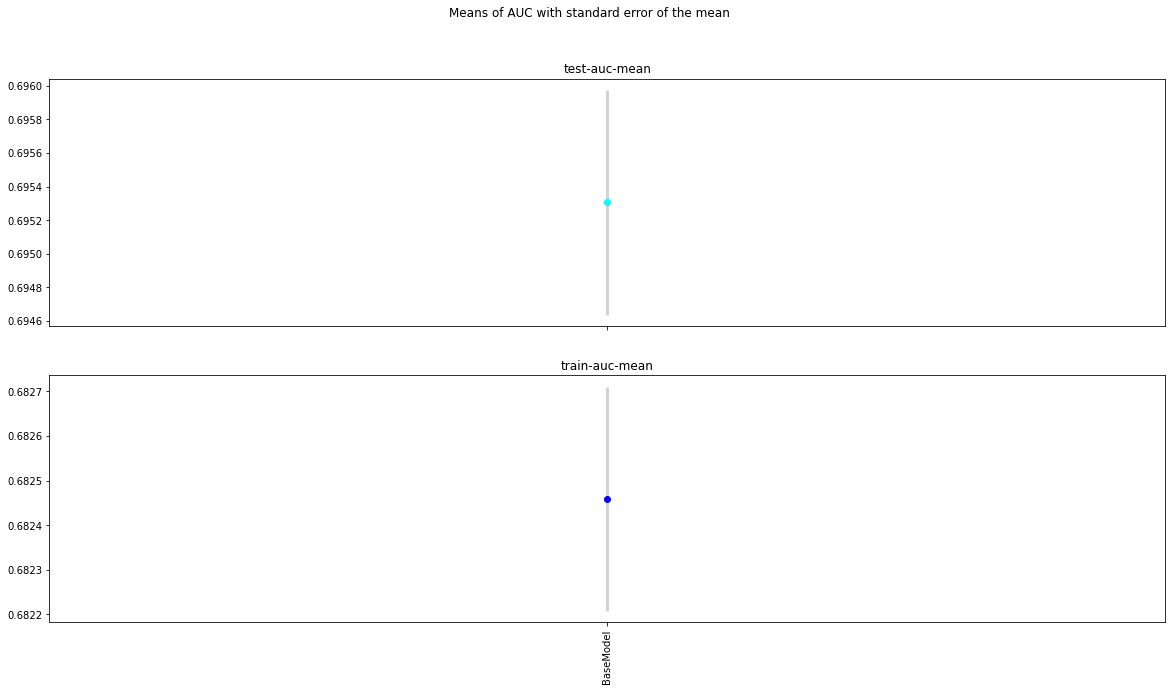

In [19]:
#Excluding from chart models which did not learn anything (0.5 is random guessing)
data = AUC_Scores[AUC_Scores['test-auc-mean']>0.5].copy()
#list of models for xticks
data['xticks']=data['Model'].astype(str) 
xticks=data['xticks'].unique().tolist()


# The x position 
r1 = np.arange(len(data))
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(20,10))
ax = axs[0]
ax.errorbar(r1, data['test-auc-mean'], color = 'cyan',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['test-auc-sem'], fmt='o')
ax.set_title('test-auc-mean')
ax = axs[1]
ax.errorbar(r1, data['train-auc-mean'],  color = 'blue',  ecolor='lightgray', elinewidth=3,capsize=0, yerr=data['train-auc-sem'],  fmt='o')
ax.set_title('train-auc-mean')
ax.set_xticks([r  for r in range(len(data))])
ax.set_xticklabels(xticks,rotation=90)
fig.suptitle('Means of AUC with standard error of the mean')

Text(0.5, 0.98, 'Means of Gini with standard error of the mean')

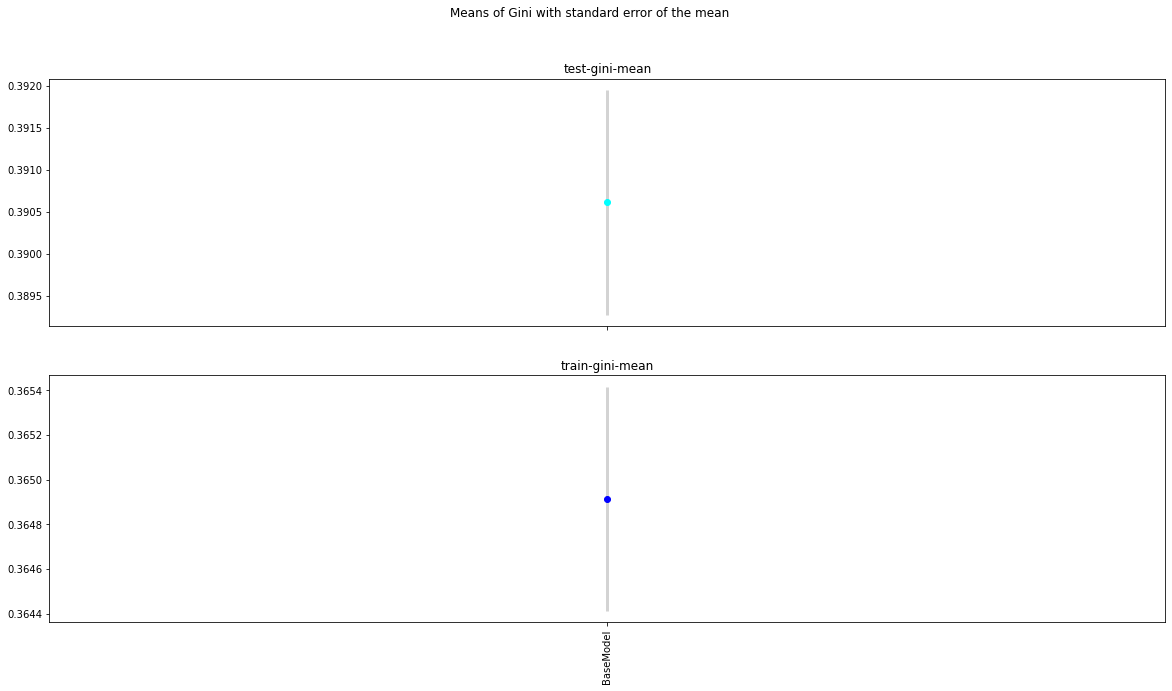

In [20]:
data = gini_Scores.copy()
#list of models for xticks
data['xticks']=data['Model'].astype(str) 
xticks=data['xticks'].unique().tolist()


# The x position 
r1 = np.arange(len(data))
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(20,10))
ax = axs[0]
ax.errorbar(r1, data['test-gini-mean'], color = 'cyan',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['test-gini-sem'], fmt='o')
ax.set_title('test-gini-mean')
ax = axs[1]
ax.errorbar(r1, data['train-gini-mean'],  color = 'blue',  ecolor='lightgray', elinewidth=3,capsize=0, yerr=data['train-gini-sem'],  fmt='o')
ax.set_title('train-gini-mean')
ax.set_xticks([r  for r in range(len(data))])
ax.set_xticklabels(xticks,rotation=90)
fig.suptitle('Means of Gini with standard error of the mean')

In [21]:
#Saving into the Experiment log 
eu.SaveToExperimentLog(Experiments_file, '%s AUC Scores'%Experiment_name, AUC_Scores)

In [22]:
#Saving into the Experiment log 
eu.SaveToExperimentLog(Experiments_file, '%s gini Scores'%Experiment_name, gini_Scores)

In [23]:
#Saving into the Experiment log 
eu.SaveToExperimentLog(Experiments_file, '%s FI'%Experiment_name, FeatureImportance)